# Análise de Dados - Portal da Transparência
Essa análise de dados foi desenvolvida com dados do próprio governo brasileiro, que se trata das viagens realizadas em 2023 pelo governo federal.


Os dados podem ser conferidos no link: https://portaldatransparencia.gov.br/download-de-dados

In [ ]:
# Definindo a variável ano, para se quisermos alterar o dataset, alteramos apenas o valor da variável.
ano = 2023

# Caminho do dataset no Drive
dataset = f"/content/drive/MyDrive/Colab Notebooks/Asimov/curso-analise-dados/{ano}_Viagem.csv"
caminho_figura = f"/content/drive/MyDrive/Colab Notebooks/Asimov/curso-analise-dados/output/{ano}_Figura.png"
caminho_saida = f"/content/drive/MyDrive/Colab Notebooks/Asimov/curso-analise-dados/output/{ano}_Tabela.xlsx"

In [ ]:
import pandas as pd

# Config para mostrar todas as colunas e a formatação dos decimais para 2 casas.
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)

# Lendo os dados da planilha, que possui o tipo Windows-1252. Sep para indicar que a coluna está separada por ';' e Decimal para indicar que os valores decimais estão separados por ','.
df_viagens = pd.read_csv(dataset, encoding="Windows-1252", sep=";", decimal=",")

# Criando a coluna de despesas
df_viagens["Valor total das despesas"] = df_viagens["Valor passagens"] + df_viagens["Valor diárias"] + df_viagens["Valor outros gastos"]

# Tratando os dados nulos do dataframe
df_viagens["Cargo"] = df_viagens["Cargo"].fillna("NÃO IDENTIFICADO")

# Formatando o tipo das colunas de datas
df_viagens["Período - Data de início"]	= pd.to_datetime(df_viagens["Período - Data de início"], format="%d/%m/%Y")
df_viagens["Período - Data de fim"] = pd.to_datetime(df_viagens["Período - Data de fim"], format="%d/%m/%Y")

# Criando novas colunas de datas
df_viagens["Mês da Viagem"] = df_viagens["Período - Data de início"].dt.month_name()
df_viagens["Dias de Viagens"] = (df_viagens["Período - Data de fim"] - df_viagens["Período - Data de início"]).dt.days

# Criando tabela consolidada
df_viagens_consolidado = (
    df_viagens
    .groupby("Cargo")
    .agg(
        despesas_media=("Valor total das despesas", "mean"),
        duracao_media=("Dias de Viagens", "mean"),
        despesas_totais=("Valor total das despesas", "sum"),
        destino_mais_frequente=("Destinos", pd.Series.mode),
        n_viagens=("Nome", "count")
        )
      .reset_index()
      .sort_values(by="despesas_totais", ascending=False)
    )

# Filtrando a tabela consolidada por cargos relevantes (> 1% das viagens)
df_cargos = df_viagens["Cargo"].value_counts(normalize=True).reset_index()
cargos_relevantes = df_cargos.loc[df_cargos["proportion"] > 0.01, "Cargo"]
filtro = df_viagens_consolidado["Cargo"].isin(cargos_relevantes)

# Carregando a tabela final já consolidada e filtrada
df_final = df_viagens_consolidado[filtro].sort_values(by="n_viagens", ascending=False)

# Salvando a tabela final e convertendo ela pra excel
df_final.to_excel(caminho_saida, index=False)

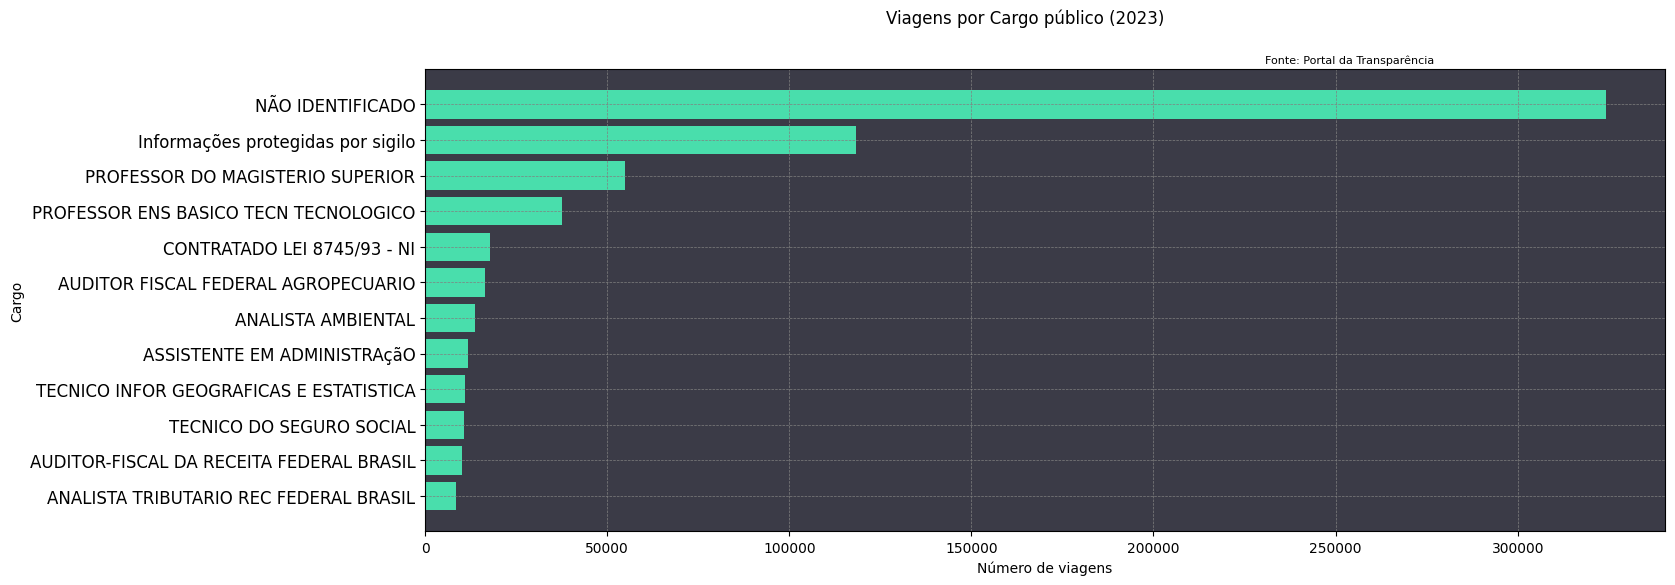

In [ ]:
import matplotlib.pyplot as plt

# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize=(16, 6))

# Pegando as colunas do dataframe para exibir e adicionando uma cor de fundo
ax.barh(df_final["Cargo"], df_final["n_viagens"], color="#49deac")

# Invertendo a ordem do gráfico
ax.invert_yaxis()

# Adicionado a cor nas barras dos gráficos
ax.set_facecolor("#3b3b47")

# Colocando um título na figura
fig.suptitle("Viagens por Cargo público (2023)")

# Colocando um subtítulo em um posição específica
plt.figtext(0.65, 0.89, "Fonte: Portal da Transparência", fontsize=8)

# Estilizando as linhas do gráfico e o configurando o tamanho delas
plt.grid(color="gray", linestyle="--", linewidth="0.5")
plt.yticks(fontsize=12)

# Adicionando a label de acordo com o dataframe
plt.xlabel("Número de viagens")
plt.ylabel("Cargo")

# Salvando a figura no caminho definido e achatando ela para a imagem ficar ajustada.
plt.savefig(caminho_figura, bbox_inches="tight")